### 1 Dataset1

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import graphviz

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
df = pd.read_csv("ha.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2943 non-null   int64  
 1   Sex             2943 non-null   int64  
 2   ChestPainType   2943 non-null   int64  
 3   RestingBP       2943 non-null   int64  
 4   Cholesterol     2943 non-null   int64  
 5   FastingBS       2943 non-null   int64  
 6   RestingECG      2943 non-null   int64  
 7   MaxHR           2943 non-null   int64  
 8   ExerciseAngina  2943 non-null   int64  
 9   Oldpeak         2943 non-null   float64
 10  HeartDisease    2943 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 253.0 KB


In [ ]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
0,40,1,1,140,289,0,0,172,0,0.0,0
1,49,0,2,160,180,0,0,156,0,1.0,1
2,37,1,1,130,283,0,1,98,0,0.0,0
3,48,0,3,138,214,0,0,108,1,1.5,1
4,54,1,2,150,195,0,0,122,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2938,59,1,1,140,221,0,1,164,1,0.0,1
2939,60,1,0,125,258,0,0,141,1,2.8,0
2940,47,1,0,110,275,0,0,118,1,1.0,0
2941,50,0,0,110,254,0,0,159,0,0.0,1


In [ ]:
risk_counts = df['HeartDisease'].value_counts()
print("HeartDisease 0 :", risk_counts[0])
print("HeartDisease 1 :", risk_counts[1])

HeartDisease 0 : 1329
HeartDisease 1 : 1614


#### 학습 : 검증 : 테스트 데이터 분할

In [ ]:
# Load the data & Preprocessing
columns = df.columns.values
input_idx = [i for i in range(8)]
target_idx = -1

Heart_input = df[columns[input_idx]]
Heart_target = df[columns[target_idx]]

In [ ]:
X_train_full, X_val, y_train_full, y_val = train_test_split(Heart_input,
                                                    Heart_target,
                                                    test_size=0.20,
                                                    random_state=2018,
                                                    stratify=Heart_target)

X_train, X_test, y_train, y_test = train_test_split(X_train_full,
                                                  y_train_full,
                                                  test_size=0.25,
                                                  random_state=2018,
                                                  stratify=y_train_full)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1765, 8)
(589, 8)
(589, 8)


### 2 full & post-pruning

In [ ]:
# Performance Evaluation Function ------------------------------------------------
def perf_eval(cm, auroc):
    _tp = cm[1, 1]
    _fn = cm[1, 0]
    _fp = cm[0, 1]
    _tn = cm[0, 0]

    # True positive rate: TPR (Recall)
    TPR = round(_tp / (_tp + _fn), 4)
    # Precision
    PRE = round(_tp / (_tp + _fp), 4)
    # True negative rate: TNR
    TNR = round(_tn / (_tn + _fp), 4)
    # Simple Accuracy
    ACC = round((_tp + _tn) / np.sum(cm), 4)
    # Balanced Correction Rate
    BCR = round(np.sqrt(TPR * TNR), 4)
    # F1-Measure
    F1 = round(2 * TPR * PRE / (TPR + PRE), 4)
    # AUROC
    AUROC = round(auroc, 4)

    return TPR, PRE, TNR, ACC, BCR, F1, AUROC

In [ ]:
# Performance table
Perf_Table = pd.DataFrame(index=["Full-tree","Post-Pruning", "Pre-Pruning"],
                          columns = ["TPR", "Precision", "TNR",
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])

In [ ]:
# Classification and Regression Tree (CART) --------------------------------------
# Training the tree
clf = DecisionTreeClassifier(random_state=2018)
CART_post = clf.fit(X_train, y_train)

In [ ]:
clf.score(X_train, y_train)

1.0

In [ ]:
clf.score(X_test, y_test)

0.8438030560271647

In [ ]:
# Prediction
CART_post_full = clf.predict(X_test)
auroc = roc_auc_score(y_test, CART_post_full)
cm = confusion_matrix(y_test, CART_post_full)
Perf_Table.iloc[0] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.8854,0.8387,0.7932,0.8438,0.838,0.8614,0.8393
Post-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN


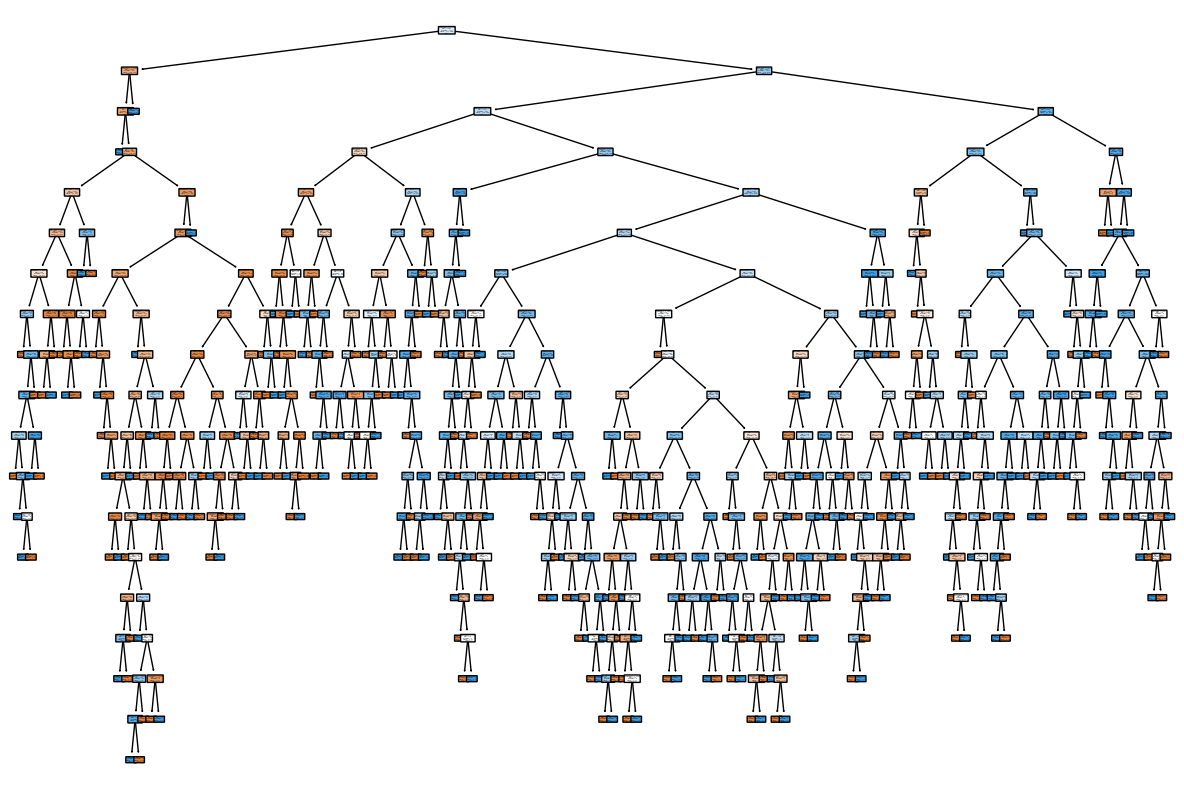

In [ ]:
# Plot the tree
fig = plt.figure(figsize=(15,10))
_ = plot_tree(clf,
              feature_names=Heart_input.columns.values,
              class_names=list(map(str, Heart_target.unique())),
              rounded=True,
              filled=True)
plt.show()

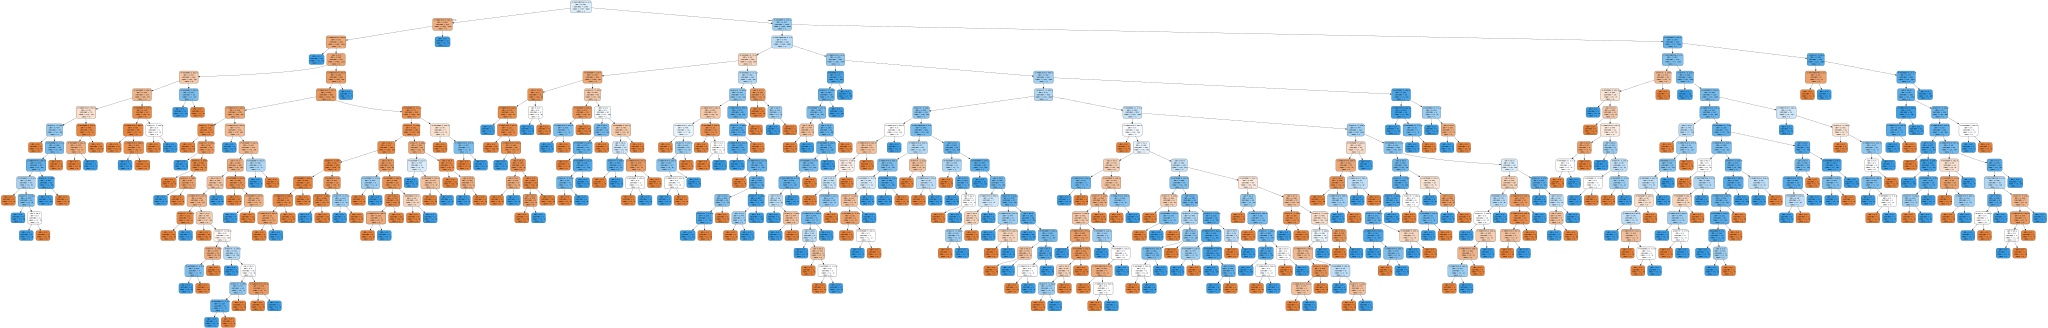

In [ ]:
dot_data = export_graphviz(clf,
                           out_file=None,
                           feature_names=Heart_input.columns.values,
                           class_names=list(map(str, Heart_target.unique())),
                           filled=True,
                           rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

#### 2 post-pruing

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

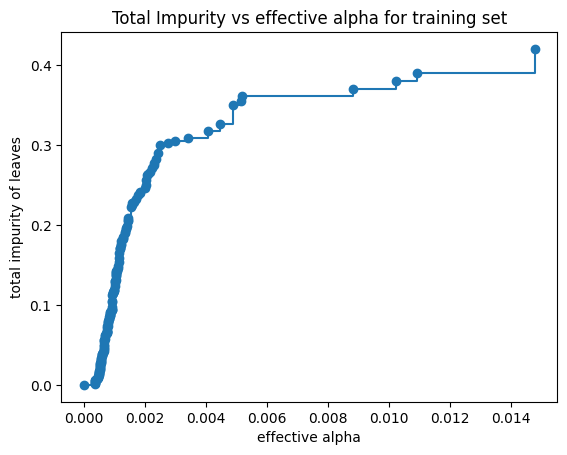

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 3 with ccp_alpha: 0.0749371369068702


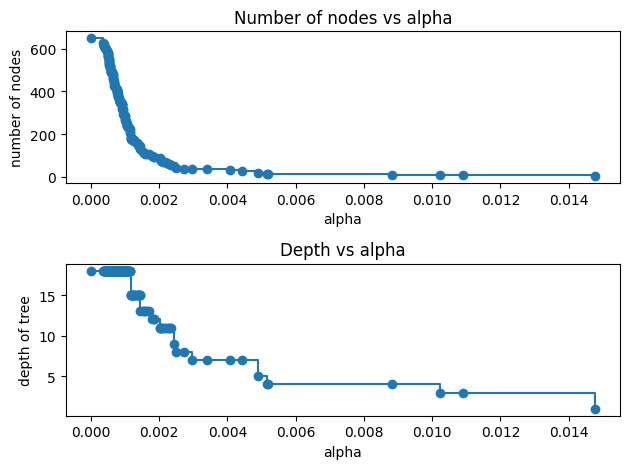

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

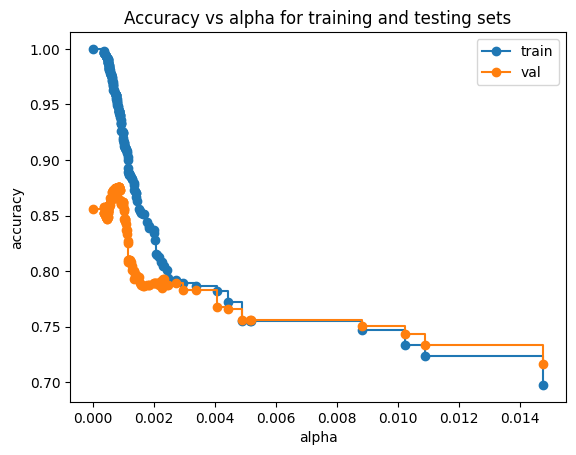

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="val", drawstyle="steps-post")
ax.legend()
plt.show()

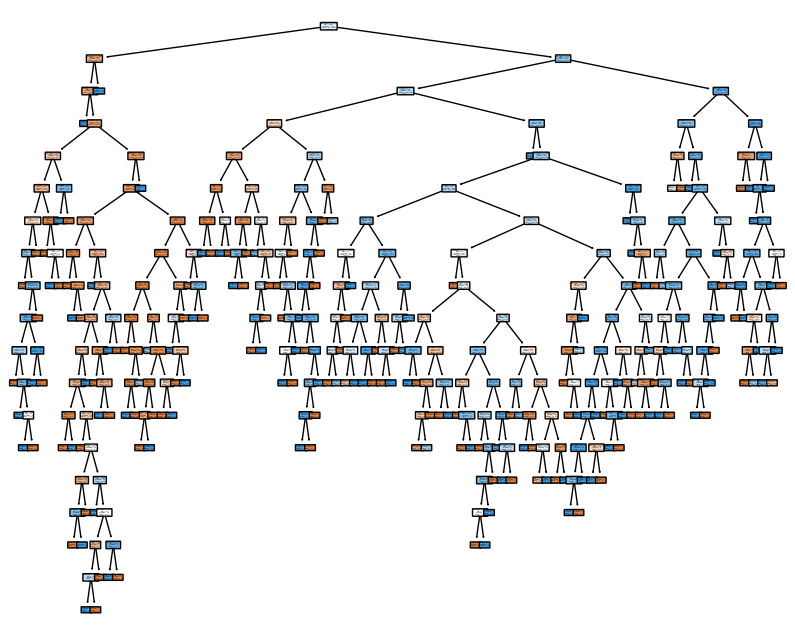

In [ ]:
best_clf = clfs[np.argmax(val_scores)]

fig = plt.figure(figsize=(10,8))
_ = plot_tree(best_clf,
              feature_names=Heart_input.columns.values,
              class_names=list(map(str, Heart_target.unique())),
              rounded=True,
              filled=True)

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source
dot_data = export_graphviz(best_clf,
                           out_file=None,
                           feature_names=Heart_input.columns.values,
                           class_names=list(map(str, Heart_target.unique())),
                           filled=True,
                           rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)
source = Source(dot_data)
source.render(filename='tree_visualization', format='png', cleanup=True)

'tree_visualization.png'

In [ ]:
best_clf = clfs[np.argmax(val_scores)]
# Prediction
CART_post_prey = best_clf.predict(X_test)
auroc = roc_auc_score(y_test, CART_post_prey)
cm = confusion_matrix(y_test, CART_post_prey)
Perf_Table.iloc[1] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.8854,0.8387,0.7932,0.8438,0.838,0.8614,0.8393
Post-Pruning,0.8947,0.8401,0.7932,0.8489,0.8424,0.8665,0.844
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4 post-prune analysis

In [ ]:
feature_names= list(X_train.columns)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

print("트리의 노드 수:", best_clf.tree_.node_count)
print("트리의 깊이:", best_clf.tree_.max_depth)


트리의 노드 수: 371
트리의 깊이: 18


In [ ]:
import numpy as np
import pandas as pd

feature_counts = np.zeros(len(feature_names))

for i in range(best_clf.tree_.node_count):
    feature_index = best_clf.tree_.feature[i]
    if feature_index != -2:
        feature_counts[feature_index] += 1

feature_usage_df = pd.DataFrame({
    'Feature': feature_names,
    'Usage Count': feature_counts
})

# 사용 횟수에 따라 정렬
feature_usage_df = feature_usage_df.sort_values(by='Usage Count', ascending=False).reset_index(drop=True)
feature_usage_df


,Feature,Usage Count
0,Cholesterol,44.0
1,MaxHR,43.0
2,RestingBP,36.0
3,Age,31.0
4,RestingECG,15.0
5,Sex,7.0
6,ChestPainType,6.0
7,FastingBS,3.0


In [ ]:
from collections import defaultdict
depth_features = defaultdict(list)

def record_features_at_depth(node, depth):
    if node == -1:
        return  # 터미널 노드(리프 노드)에 도달하면 종료
    feature_index = best_clf.tree_.feature[node]
    if feature_index != -2:  # 내부 노드인 경우
        feature_name = feature_names[feature_index]
        if feature_name not in depth_features[depth]:
            depth_features[depth].append(feature_name)

    record_features_at_depth(best_clf.tree_.children_left[node], depth + 1)
    record_features_at_depth(best_clf.tree_.children_right[node], depth + 1)

record_features_at_depth(0, 1)


for depth in sorted(depth_features):
    print(f"Depth {depth}: {depth_features[depth]}")


Depth 1: ['ChestPainType']
Depth 2: ['Cholesterol', 'RestingBP']
Depth 3: ['Cholesterol', 'ChestPainType', 'RestingBP']
Depth 4: ['Sex', 'RestingECG', 'Cholesterol', 'ChestPainType', 'MaxHR']
Depth 5: ['RestingBP', 'Cholesterol', 'RestingECG', 'MaxHR', 'ChestPainType']
Depth 6: ['RestingBP', 'Cholesterol', 'Age', 'MaxHR']
Depth 7: ['Cholesterol', 'RestingBP', 'RestingECG', 'Sex', 'MaxHR']
Depth 8: ['MaxHR', 'Cholesterol', 'RestingBP', 'ChestPainType', 'Age', 'RestingECG']
Depth 9: ['RestingECG', 'MaxHR', 'RestingBP', 'Age', 'Cholesterol', 'Sex']
Depth 10: ['Cholesterol', 'Age', 'RestingBP', 'MaxHR', 'RestingECG', 'Sex']
Depth 11: ['RestingECG', 'MaxHR', 'Age', 'RestingBP', 'FastingBS', 'Cholesterol', 'ChestPainType']
Depth 12: ['MaxHR', 'Cholesterol', 'RestingBP', 'Age', 'FastingBS', 'Sex']
Depth 13: ['Age', 'MaxHR', 'Cholesterol']
Depth 14: ['MaxHR', 'Age', 'RestingBP']
Depth 15: ['MaxHR', 'Cholesterol']
Depth 16: ['RestingBP']
Depth 17: ['Age', 'RestingECG']
Depth 18: ['Cholesterol']

In [ ]:
from collections import defaultdict
feature_importance = defaultdict(float)

def calculate_importance(node, depth):
    if node == -1:
        return
    feature_index = best_clf.tree_.feature[node]
    if feature_index != -2:  # 내부 노드인 경우
        feature_importance[feature_names[feature_index]] += (best_clf.tree_.max_depth + 1 - depth)

    calculate_importance(best_clf.tree_.children_left[node], depth + 1)
    calculate_importance(best_clf.tree_.children_right[node], depth + 1)

calculate_importance(0, 1)

importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df


,Feature,Importance
0,Cholesterol,436.0
1,MaxHR,377.0
2,RestingBP,340.0
3,Age,261.0
4,RestingECG,153.0
5,ChestPainType,82.0
6,Sex,72.0
7,FastingBS,23.0


In [ ]:
import pandas as pd
from collections import defaultdict
node_efficiency = []

def evaluate_node_efficiency(node, parent_impurity):
    if node == -1:
        return

    current_impurity = best_clf.tree_.impurity[node]

    impurity_decrease = parent_impurity - current_impurity
    feature_index = best_clf.tree_.feature[node]
    if feature_index != -2:
        feature_name = feature_names[feature_index]
        threshold = best_clf.tree_.threshold[node]
        node_efficiency.append((feature_name, threshold, impurity_decrease))

    evaluate_node_efficiency(best_clf.tree_.children_left[node], current_impurity)
    evaluate_node_efficiency(best_clf.tree_.children_right[node], current_impurity)

root_impurity = best_clf.tree_.impurity[0]
evaluate_node_efficiency(0, root_impurity)

efficiency_df = pd.DataFrame(node_efficiency, columns=['Feature', 'Threshold', 'Impurity Decrease'])
efficiency_df = efficiency_df.sort_values(by='Impurity Decrease', ascending=False).reset_index(drop=True)
efficiency_df.head()


,Feature,Threshold,Impurity Decrease
0,RestingBP,139.5,0.316715
1,MaxHR,192.0,0.295384
2,RestingBP,179.0,0.285937
3,MaxHR,137.0,0.272987
4,MaxHR,165.0,0.271046


In [ ]:
import pandas as pd

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_clf.feature_importances_
}).sort_values(by='importance', ascending=False)
feature_importances


,feature,importance
2,ChestPainType,0.240662
4,Cholesterol,0.222415
3,RestingBP,0.181707
7,MaxHR,0.141041
0,Age,0.102965
6,RestingECG,0.073664
1,Sex,0.028481
5,FastingBS,0.009065


### 3 pre-pruning

In [ ]:
# Tree parameter settings
criterion = ["gini", "entropy", "log_loss"]
min_samples_leaf = [8, 16, 32, 64]
max_depth = [7, 9, 13 , 15]

param_grid = {
    'criterion': criterion,
    'min_samples_leaf': min_samples_leaf,
    'max_depth': max_depth
}

In [ ]:
# Fit the decision tree model and evaluate the results
model = DecisionTreeClassifier(random_state=2018)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_criterion = grid.best_params_['criterion']
best_leaf = grid.best_params_['min_samples_leaf']
best_depth = grid.best_params_['max_depth']

print("Best criterion:", best_criterion)
print("Best min_samples_leaf:", best_leaf)
print("Best max_depth:", best_depth)

# Evaluate the best model on the validation data
y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best criterion: gini
Best min_samples_leaf: 8
Best max_depth: 15
Confusion matrix:
 [[213  53]
 [ 59 264]]
ROC AUC: 0.8090446704997789


In [ ]:
# Prediction
CART_pre_prediction = grid.predict(X_test)
auroc = roc_auc_score(y_test, CART_pre_prediction)
cm = confusion_matrix(y_test, CART_pre_prediction)
Perf_Table.iloc[2] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.8854,0.8387,0.7932,0.8438,0.838,0.8614,0.8393
Post-Pruning,0.8947,0.8401,0.7932,0.8489,0.8424,0.8665,0.844
Pre-Pruning,0.8173,0.8328,0.8008,0.8098,0.809,0.825,0.809


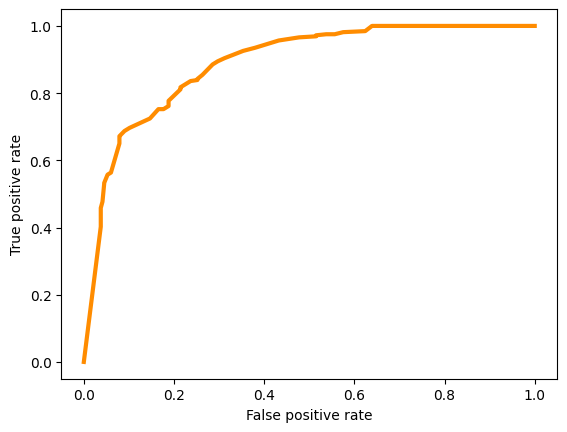

In [ ]:
# Plot the ROC
CART_pre_prob = grid.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, CART_pre_prob)
plt.plot(fpr, tpr, color='darkorange', lw=3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

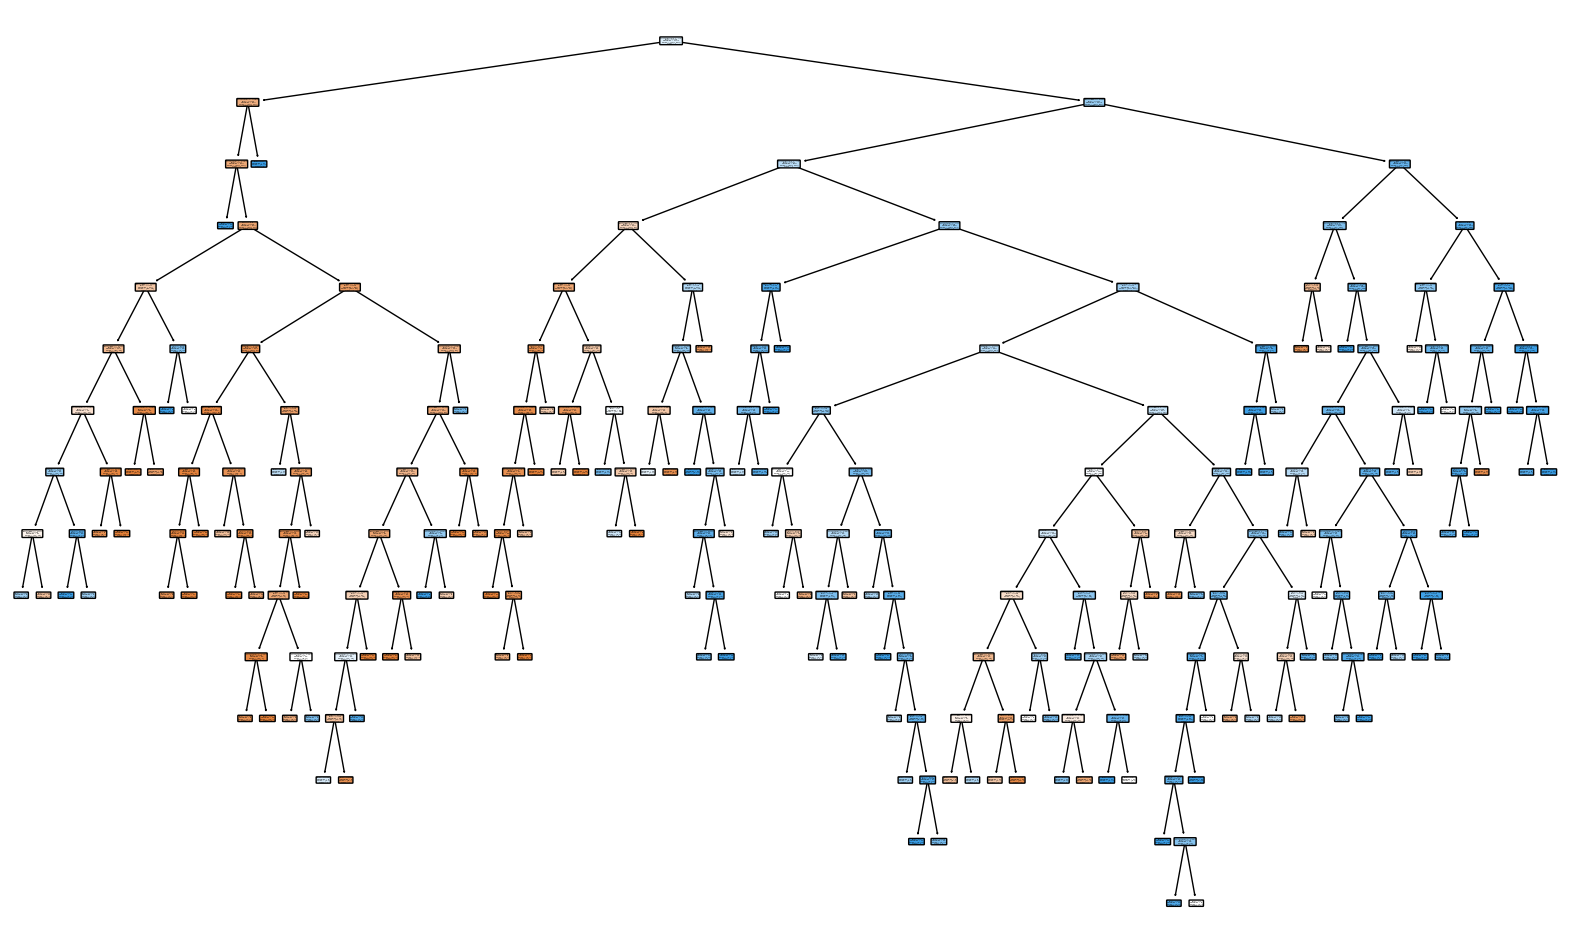

In [ ]:
# Plot the best tree
CART_pre = DecisionTreeClassifier(**grid.best_params_)
CART_pre.fit(X_train,y_train)
plt.figure(figsize=(20,12))
plot_tree(CART_pre,
          feature_names=Heart_input.columns.values,
          class_names=list(map(str, Heart_target.unique())),
          rounded=True,
          filled=True)
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source
dot_data = export_graphviz(CART_pre,
                           out_file=None,
                           feature_names=Heart_input.columns.values,
                           class_names=list(map(str, Heart_target.unique())),
                           filled=True,
                           rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)
source = Source(dot_data)
source.render(filename='pre_prune', format='png', cleanup=True)

'pre_prune.png'

#### 4 pre-prune anlaysis

In [ ]:
from sklearn.tree import DecisionTreeClassifier
print("트리의 노드 수:", CART_pre.tree_.node_count)
print("트리의 깊이:", CART_pre.tree_.max_depth)

트리의 노드 수: 249
트리의 깊이: 14


In [ ]:
import numpy as np
import pandas as pd

feature_counts = np.zeros(len(feature_names))

for i in range(CART_pre.tree_.node_count):
    feature_index = CART_pre.tree_.feature[i]
    if feature_index != -2:
        feature_counts[feature_index] += 1

feature_usage_df = pd.DataFrame({
    'Feature': feature_names,
    'Usage Count': feature_counts
})

# 사용 횟수에 따라 정렬
feature_usage_df = feature_usage_df.sort_values(by='Usage Count', ascending=False).reset_index(drop=True)
feature_usage_df

,Feature,Usage Count
0,Cholesterol,36.0
1,RestingBP,25.0
2,Age,23.0
3,MaxHR,21.0
4,ChestPainType,7.0
5,RestingECG,7.0
6,Sex,4.0
7,FastingBS,1.0


In [ ]:
from collections import defaultdict
depth_features = defaultdict(list)

def record_features_at_depth(node, depth):
    if node == -1:
        return  # 터미널 노드(리프 노드)에 도달하면 종료
    feature_index = CART_pre.tree_.feature[node]
    if feature_index != -2:  # 내부 노드인 경우
        feature_name = feature_names[feature_index]
        if feature_name not in depth_features[depth]:
            depth_features[depth].append(feature_name)

    record_features_at_depth(CART_pre.tree_.children_left[node], depth + 1)
    record_features_at_depth(CART_pre.tree_.children_right[node], depth + 1)

record_features_at_depth(0, 1)


for depth in sorted(depth_features):
    print(f"Depth {depth}: {depth_features[depth]}")


Depth 1: ['ChestPainType']
Depth 2: ['Cholesterol', 'RestingBP']
Depth 3: ['Cholesterol', 'ChestPainType', 'RestingBP']
Depth 4: ['Sex', 'RestingECG', 'Cholesterol', 'ChestPainType']
Depth 5: ['RestingBP', 'RestingECG', 'FastingBS', 'Cholesterol', 'Age', 'MaxHR']
Depth 6: ['RestingBP', 'Age', 'MaxHR', 'Cholesterol', 'ChestPainType']
Depth 7: ['Cholesterol', 'RestingECG', 'MaxHR', 'RestingBP', 'Sex', 'ChestPainType']
Depth 8: ['MaxHR', 'RestingBP', 'Cholesterol', 'ChestPainType', 'RestingECG', 'Age']
Depth 9: ['RestingBP', 'Age', 'Cholesterol', 'Sex', 'MaxHR', 'RestingECG']
Depth 10: ['RestingBP', 'Cholesterol', 'MaxHR', 'Age']
Depth 11: ['Cholesterol', 'Age', 'RestingBP', 'MaxHR']
Depth 12: ['MaxHR', 'RestingBP', 'Age', 'Cholesterol']
Depth 13: ['Age', 'MaxHR']
Depth 14: ['Cholesterol']


In [ ]:
from collections import defaultdict
feature_importance = defaultdict(float)

def calculate_importance(node, depth):
    if node == -1:
        return
    feature_index = CART_pre.tree_.feature[node]
    if feature_index != -2:  # 내부 노드인 경우
        feature_importance[feature_names[feature_index]] += (CART_pre.tree_.max_depth + 1 - depth)

    calculate_importance(CART_pre.tree_.children_left[node], depth + 1)
    calculate_importance(CART_pre.tree_.children_right[node], depth + 1)

calculate_importance(0, 1)

importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df


,Feature,Importance
0,Cholesterol,243.0
1,RestingBP,189.0
2,MaxHR,137.0
3,Age,128.0
4,ChestPainType,70.0
5,RestingECG,60.0
6,Sex,36.0
7,FastingBS,10.0


In [ ]:
import pandas as pd
from collections import defaultdict
node_efficiency = []

def evaluate_node_efficiency(node, parent_impurity):
    if node == -1:
        return

    current_impurity = CART_pre.tree_.impurity[node]

    impurity_decrease = parent_impurity - current_impurity
    feature_index = CART_pre.tree_.feature[node]
    if feature_index != -2:
        feature_name = feature_names[feature_index]
        threshold = CART_pre.tree_.threshold[node]
        node_efficiency.append((feature_name, threshold, impurity_decrease))

    evaluate_node_efficiency(CART_pre.tree_.children_left[node], current_impurity)
    evaluate_node_efficiency(CART_pre.tree_.children_right[node], current_impurity)

root_impurity = CART_pre.tree_.impurity[0]
evaluate_node_efficiency(0, root_impurity)

efficiency_df = pd.DataFrame(node_efficiency, columns=['Feature', 'Threshold', 'Impurity Decrease'])
efficiency_df = efficiency_df.sort_values(by='Impurity Decrease', ascending=False).reset_index(drop=True)
efficiency_df.head()


,Feature,Threshold,Impurity Decrease
0,RestingBP,127.0,0.421477
1,RestingBP,139.5,0.316715
2,MaxHR,157.5,0.292823
3,Cholesterol,316.0,0.285937
4,Age,53.0,0.282371


In [ ]:
import pandas as pd

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': CART_pre.feature_importances_
}).sort_values(by='importance', ascending=False)
feature_importances


,feature,importance
2,ChestPainType,0.325427
4,Cholesterol,0.251044
3,RestingBP,0.171005
7,MaxHR,0.105019
6,RestingECG,0.067318
0,Age,0.049180
1,Sex,0.025291
5,FastingBS,0.005715


### 5 optimize decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

tree_rules = export_text(CART_pre, feature_names=list(Heart_input.columns), spacing=3, decimals=2)
#print(tree_rules)


def get_top_rules(tree, feature_names, num_rules=3):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    leaf_ids = [i for i in range(n_nodes) if children_left[i] == -1 and children_right[i] == -1]
    paths = []
    for leaf in leaf_ids:
        path = []
        while leaf != 0:
            parent = np.where((children_left == leaf) | (children_right == leaf))[0].item()
            if leaf == children_right[parent]:
                path.append(f"{feature_names[feature[parent]]} > {threshold[parent]:.2f}")
            else:
                path.append(f"{feature_names[feature[parent]]} <= {threshold[parent]:.2f}")
            leaf = parent
        paths.append(" and ".join(reversed(path)))

    leaf_samples = tree.tree_.n_node_samples[leaf_ids]
    top_leaf_ids = np.argsort(leaf_samples)[-num_rules:]
    return [paths[i] for i in top_leaf_ids]

# 대표적인 규칙 3개 출력
top_rules = get_top_rules(CART_pre, list(Heart_input.columns))
for i, rule in enumerate(top_rules, 1):
    print(f"Rule {i}: {rule}")


Rule 1: ChestPainType > 0.50 and RestingBP <= 143.50 and ChestPainType > 1.50 and Cholesterol <= 42.50 and FastingBS > 0.50
Rule 2: ChestPainType <= 0.50 and Cholesterol <= 468.00 and Cholesterol > 109.00 and Sex > 0.50 and RestingBP <= 138.50 and MaxHR <= 144.50 and RestingECG <= 0.50 and RestingBP > 110.50
Rule 3: ChestPainType > 0.50 and RestingBP > 143.50 and RestingBP > 160.50 and Sex > 0.50 and RestingECG > 0.50 and ChestPainType <= 2.50


ChestPainType
0    963
2    799
3    617
1    564
Name: count, dtype: int64


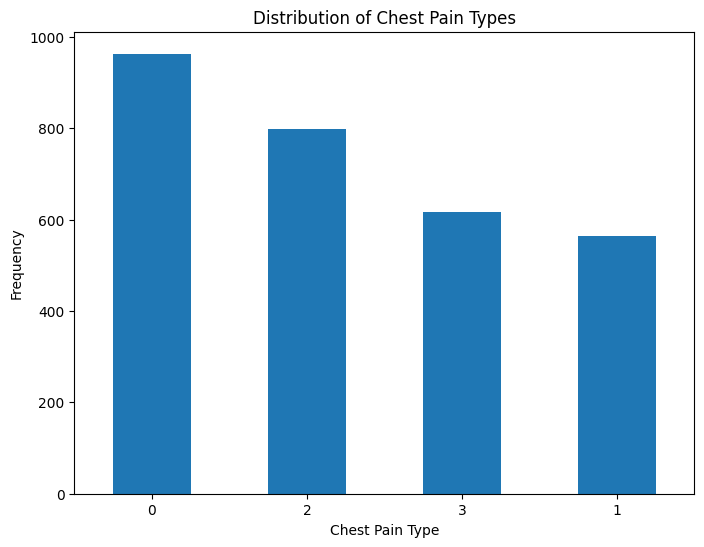

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

chest_pain_counts = Heart_input['ChestPainType'].value_counts()
print(chest_pain_counts)

plt.figure(figsize=(8, 6))
chest_pain_counts.plot(kind='bar')
plt.title('Distribution of Chest Pain Types')
plt.xlabel('Chest Pain Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


### 6 NN

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Performance table
Perf_Table = pd.DataFrame(index=["Logistic Regression", "Decision Tree","Neural Network"],
                          columns = ["TPR", "Precision", "TNR",
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])

In [ ]:
# Load the data & Preprocessing
columns = df.columns.values
input_idx = [i for i in range(8)]
target_idx = -1

Heart_input = df[columns[input_idx]]
Heart_target = df[columns[target_idx]]

In [ ]:
# Normalize the input data
scaler = StandardScaler()
Heart_input_normalized = scaler.fit_transform(Heart_input)

# Split data into training and test sets
Heart_input_train, Heart_input_test, Heart_target_train, Heart_target_test = train_test_split(Heart_input_normalized,
                                                                                          Heart_target,
                                                                                          test_size=0.2,
                                                                                          random_state=2018)

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import pandas as pd

# 데이터셋 정의 (numpy 배열로 변환)
ann_trn_input = np.array(Heart_input_train)
ann_trn_target = np.array(Heart_target_train)
ann_val_input = np.array(Heart_input_test)
ann_val_target = np.array(Heart_target_test)

# 하이퍼파라미터 후보 값 정의
hidden_layer_sizes = [5, 10, 15, 20, 25, 30]
learning_rate_init = [0.001, 0.01, 0.1]
activations = ['identity', 'logistic', 'tanh', 'relu']

# 5-fold cross validation
kf = KFold(n_splits=5)
best_params = None
best_score = -1

for hidden_nodes in hidden_layer_sizes:
    for lr in learning_rate_init:
        for activation in activations:
            print(f"Training ANN: hidden_nodes={hidden_nodes}, learning_rate_init={lr}, activation={activation}")
            eval_fold = []

            for train_index, val_index in kf.split(ann_trn_input):
                tmp_trn_input = ann_trn_input[train_index]
                tmp_trn_target = ann_trn_target[train_index]
                tmp_val_input = ann_trn_input[val_index]
                tmp_val_target = ann_trn_target[val_index]

                # 모델 정의 및 학습
                tmp_nnet = MLPClassifier(hidden_layer_sizes=(hidden_nodes,), learning_rate_init=lr, activation=activation, max_iter=500)
                tmp_nnet.fit(tmp_trn_input, tmp_trn_target)

                # 모델 평가
                val_predictions = tmp_nnet.predict_proba(tmp_val_input)[:, 1]
                eval_fold.append(roc_auc_score(tmp_val_target, val_predictions))

            # 평균 AUROC 계산
            avg_auroc = np.mean(eval_fold)
            print(f"Avg AUROC for hidden_nodes={hidden_nodes}, learning_rate_init={lr}, activation={activation}: {avg_auroc}")

            # 최적 하이퍼파라미터 갱신
            if avg_auroc > best_score:
                best_score = avg_auroc
                best_params = (hidden_nodes, lr, activation)

print(f"Best hyperparameters: hidden_nodes={best_params[0]}, learning_rate_init={best_params[1]}, activation={best_params[2]}")
print(f"Best AUROC: {best_score}")

best_hidden_nodes, best_lr, best_activation = best_params
final_model = MLPClassifier(hidden_layer_sizes=(best_hidden_nodes,), learning_rate_init=best_lr, activation=best_activation, max_iter=500)
final_model.fit(ann_trn_input, ann_trn_target)

final_predictions = final_model.predict_proba(ann_val_input)[:, 1]
final_auroc = roc_auc_score(ann_val_target, final_predictions)

print(f"Final AUROC on validation data: {final_auroc}")


Training ANN: hidden_nodes=5, learning_rate_init=0.001, activation=identity
Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=identity: 0.797961585731827
Training ANN: hidden_nodes=5, learning_rate_init=0.001, activation=logistic
Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=logistic: 0.8018571307651314
Training ANN: hidden_nodes=5, learning_rate_init=0.001, activation=tanh
Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=tanh: 0.8226268007652108
Training ANN: hidden_nodes=5, learning_rate_init=0.001, activation=relu
Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=relu: 0.8264447016326312
Training ANN: hidden_nodes=5, learning_rate_init=0.01, activation=identity
Avg AUROC for hidden_nodes=5, learning_rate_init=0.01, activation=identity: 0.7971993470296057
Training ANN: hidden_nodes=5, learning_rate_init=0.01, activation=logistic
Avg AUROC for hidden_nodes=5, learning_rate_init=0.01, activation=logistic: 0.821754

In [ ]:
# Prediction
NN_predict = final_model.predict(Heart_input_test)
auroc = roc_auc_score(Heart_target_test, NN_predict)
cm = confusion_matrix(Heart_target_test, NN_predict)
Perf_Table.iloc[2] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neural Network,0.8249,0.8105,0.7421,0.7895,0.7824,0.8176,0.7835


### 7 DT / NN / LR
  

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(solver='liblinear', random_state=2018)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 정규화 강도
    'penalty': ['l1', 'l2']        # 정규화 유형
}
# GridSearchCV 설정
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_val, y_val)

best_params_valid = grid_search.best_params_
best_score_valid = grid_search.best_score_
best_params_valid, best_score_valid

Fitting 5 folds for each of 10 candidates, totalling 50 fits


({'C': 1, 'penalty': 'l2'}, 0.7789709955896285)

In [ ]:
lr_model = LogisticRegression(solver='liblinear', C=1, penalty='l1', random_state=2018)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

auroc = roc_auc_score(y_test, lr_pred)
cm = confusion_matrix(y_test, lr_pred)
Perf_Table.iloc[0] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic Regression,0.808,0.7632,0.6955,0.7572,0.7496,0.785,0.7518
Decision Tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neural Network,0.8249,0.8105,0.7421,0.7895,0.7824,0.8176,0.7835


In [ ]:
CART_pre_prediction = grid.predict(X_test)
auroc = roc_auc_score(y_test, CART_pre_prediction)
cm = confusion_matrix(y_test, CART_pre_prediction)
Perf_Table.iloc[1] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic Regression,0.808,0.7632,0.6955,0.7572,0.7496,0.785,0.7518
Decision Tree,0.8173,0.8328,0.8008,0.8098,0.809,0.825,0.809
Neural Network,0.8249,0.8105,0.7421,0.7895,0.7824,0.8176,0.7835


### 8 Dataset2

In [ ]:
df2 = pd.read_csv("booking.csv")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [ ]:
df2.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [ ]:
cancel_counts = df2['booking status'].value_counts()
print("booking status 0 :", cancel_counts[0])
print("booking status 1 :", cancel_counts[1])

booking status 0 : 24396
booking status 1 : 11889


In [ ]:
df2['booking'] = df2['booking status'].map({'Not_Canceled': 0, 'Canceled': 1})
df2

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status,booking
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled,0
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled,0
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled,1
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled,1
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36280,INN36282,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,Online,0,0,0,115.00,1,9/13/2018,Canceled,1
36281,INN36283,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,Online,0,0,0,107.55,1,10/15/2017,Not_Canceled,0
36282,INN36284,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,Online,0,0,0,105.61,1,12/26/2018,Not_Canceled,0
36283,INN36285,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,Offline,0,0,0,96.90,1,7/6/2018,Not_Canceled,0


In [ ]:
# Load the data & Preprocessing
columns = df2.columns.values
input_idx = [1,2,3,4,6,8,13,14]
target_idx = -1

Book_input = df2[columns[input_idx]]
Book_target = df2[columns[target_idx]]

In [ ]:
X_train_full, X_val, y_train_full, y_val = train_test_split(Book_input,
                                                    Book_target,
                                                    test_size=0.20,
                                                    random_state=2018,
                                                    stratify=Book_target)

X_train, X_test, y_train, y_test = train_test_split(X_train_full,
                                                  y_train_full,
                                                  test_size=0.25,
                                                  random_state=2018,
                                                  stratify=y_train_full)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(21771, 8)
(7257, 8)
(7257, 8)


### 9 pre-pruning / NN

#### 최적의 pre-pruning DT 모델 찾기

In [ ]:
# Tree parameter settings
criterion = ["gini", "entropy", "log_loss"]
min_samples_leaf = [2, 4, 8, 16, 32]
max_depth = [7, 9, 13 , 15]

param_grid = {
    'criterion': criterion,
    'min_samples_leaf': min_samples_leaf,
    'max_depth': max_depth
}

In [ ]:
# Fit the decision tree model and evaluate the results
model = DecisionTreeClassifier(random_state=2018)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_criterion = grid.best_params_['criterion']
best_leaf = grid.best_params_['min_samples_leaf']
best_depth = grid.best_params_['max_depth']

print("Best criterion:", best_criterion)
print("Best min_samples_leaf:", best_leaf)
print("Best max_depth:", best_depth)

# Evaluate the best model on the validation data
y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best criterion: entropy
Best min_samples_leaf: 8
Best max_depth: 13
Confusion matrix:
 [[4483  396]
 [ 785 1593]]
ROC AUC: 0.794363245718809


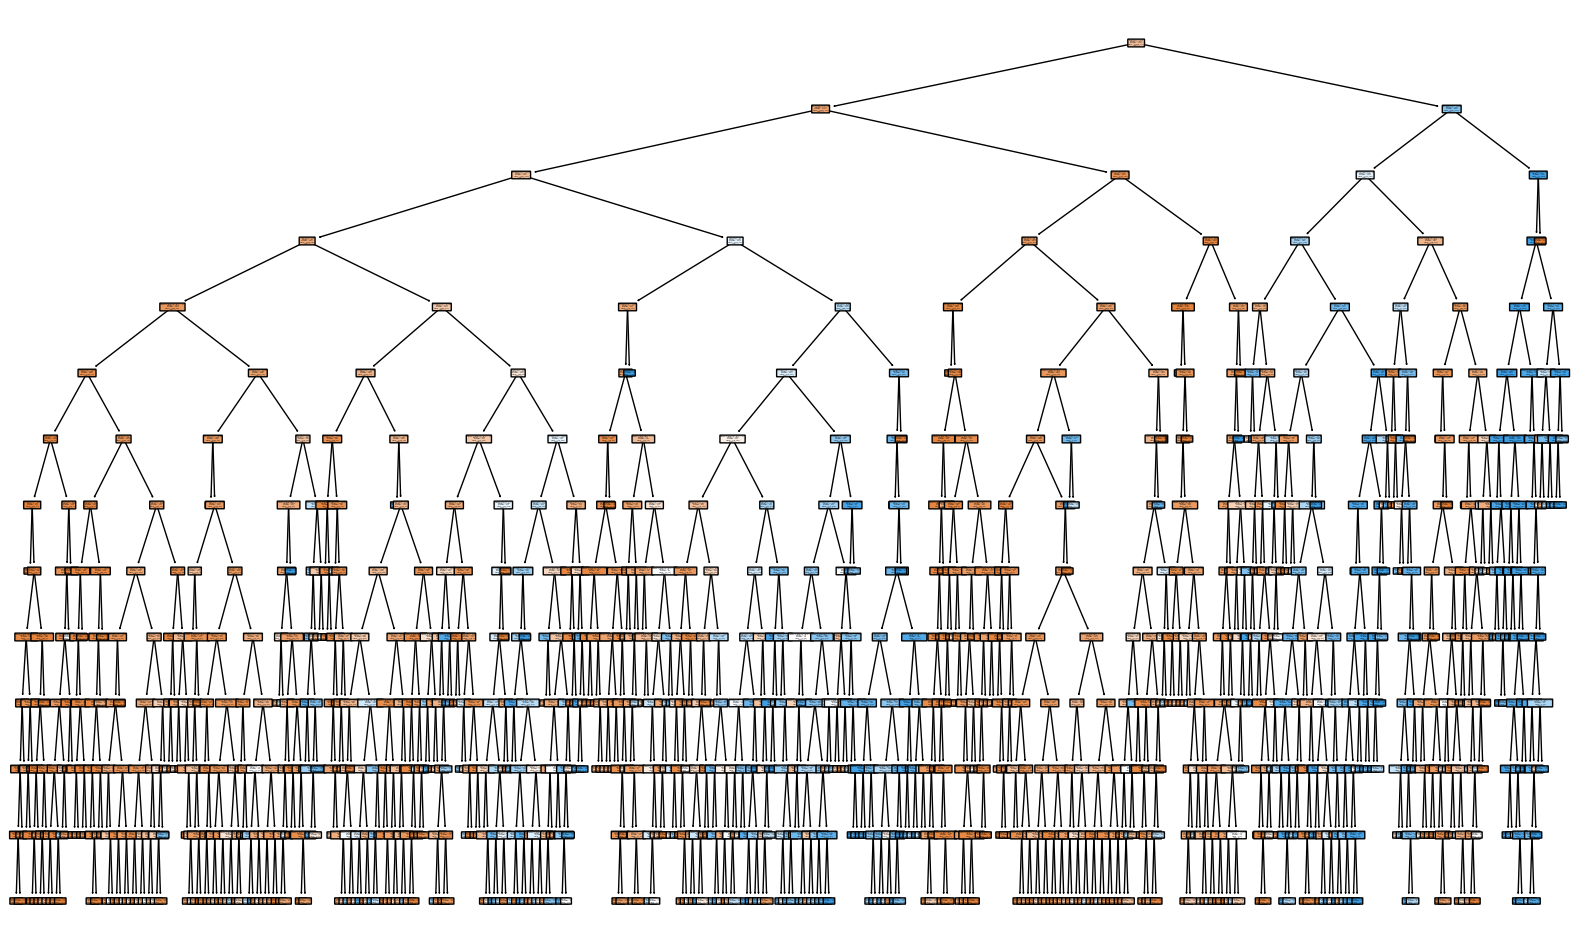

In [ ]:
# Plot the best tree
CART_pre = DecisionTreeClassifier(**grid.best_params_)
CART_pre.fit(X_train,y_train)
plt.figure(figsize=(20,12))
plot_tree(CART_pre,
          feature_names=Book_input.columns.values,
          class_names=list(map(str, Book_target.unique())),
          rounded=True,
          filled=True)
plt.show()

In [ ]:
# Performance table
Perf_Table = pd.DataFrame(index=["Logistic Regression", "Decision Tree","Neural Network"],
                          columns = ["TPR", "Precision", "TNR",
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])

In [ ]:
# Prediction
CART_pre_prediction = grid.predict(X_test)
auroc = roc_auc_score(y_test, CART_pre_prediction)
cm = confusion_matrix(y_test, CART_pre_prediction)
Perf_Table.iloc[1] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic Regression,0.5367,0.7181,0.9003,0.7835,0.6951,0.6143,0.7185
Decision Tree,0.6699,0.8009,0.9188,0.8373,0.7845,0.7296,0.7944
Neural Network,0.6255,0.7722,0.9127,0.8204,0.7556,0.6912,0.8735


In [ ]:
cm

array([[4483,  396],
       [ 785, 1593]])

In [ ]:
np.array(Book_target_test)

array([1, 0, 0, ..., 0, 0, 0])

#### 최적의 Neural Network 모델 찾기

In [ ]:
# Normalize the input data
scaler = StandardScaler()
Book_input_normalized = scaler.fit_transform(Book_input)

# Split data into training and test sets
Book_input_train, Book_input_test, Book_target_train, Book_target_test = train_test_split(Book_input_normalized,
                                                                                          Book_target,
                                                                                          test_size=0.2,
                                                                                          random_state=2018)

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import pandas as pd

# 데이터셋 정의 (numpy 배열로 변환)
ann_trn_input = np.array(Book_input_train)
ann_trn_target = np.array(Book_target_train)
ann_val_input = np.array(Book_input_test)
ann_val_target = np.array(Book_target_test)

# 하이퍼파라미터 후보 값 정의
hidden_layer_sizes = [5, 10, 15, 20, 25, 30]
learning_rate_init = [0.001, 0.01, 0.1]
activations = ['identity', 'logistic', 'tanh', 'relu']

# 5-fold cross validation
kf = KFold(n_splits=5)
best_params = None
best_score = -1

for hidden_nodes in hidden_layer_sizes:
    for lr in learning_rate_init:
        for activation in activations:
            #print(f"Training ANN: hidden_nodes={hidden_nodes}, learning_rate_init={lr}, activation={activation}")
            eval_fold = []

            for train_index, val_index in kf.split(ann_trn_input):
                tmp_trn_input = ann_trn_input[train_index]
                tmp_trn_target = ann_trn_target[train_index]
                tmp_val_input = ann_trn_input[val_index]
                tmp_val_target = ann_trn_target[val_index]

                # 모델 정의 및 학습
                tmp_nnet = MLPClassifier(hidden_layer_sizes=(hidden_nodes,), learning_rate_init=lr, activation=activation, max_iter=500)
                tmp_nnet.fit(tmp_trn_input, tmp_trn_target)

                # 모델 평가
                val_predictions = tmp_nnet.predict_proba(tmp_val_input)[:, 1]
                eval_fold.append(roc_auc_score(tmp_val_target, val_predictions))

            # 평균 AUROC 계산
            avg_auroc = np.mean(eval_fold)
            print(f"Avg AUROC for hidden_nodes={hidden_nodes}, learning_rate_init={lr}, activation={activation}: {avg_auroc}")

            # 최적 하이퍼파라미터 갱신
            if avg_auroc > best_score:
                best_score = avg_auroc
                best_params = (hidden_nodes, lr, activation)

print(f"Best hyperparameters: hidden_nodes={best_params[0]}, learning_rate_init={best_params[1]}, activation={best_params[2]}")
print(f"Best AUROC: {best_score}")

# 최적 하이퍼파라미터로 모델 재학습
best_hidden_nodes, best_lr, best_activation = best_params
final_model = MLPClassifier(hidden_layer_sizes=(best_hidden_nodes,), learning_rate_init=best_lr, activation=best_activation, max_iter=500)
final_model.fit(ann_trn_input, ann_trn_target)

# 검증 데이터에 대한 예측 및 AUROC 계산
final_predictions = final_model.predict_proba(ann_val_input)[:, 1]
final_auroc = roc_auc_score(ann_val_target, final_predictions)

print(f"Final AUROC on validation data: {final_auroc}")


Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=identity: 0.8255933922580422
Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=logistic: 0.8427827926104567
Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=tanh: 0.8428156935433051
Avg AUROC for hidden_nodes=5, learning_rate_init=0.001, activation=relu: 0.8433060629609394
Avg AUROC for hidden_nodes=5, learning_rate_init=0.01, activation=identity: 0.8250318909568041
Avg AUROC for hidden_nodes=5, learning_rate_init=0.01, activation=logistic: 0.8445406573935876
Avg AUROC for hidden_nodes=5, learning_rate_init=0.01, activation=tanh: 0.8440089286083048
Avg AUROC for hidden_nodes=5, learning_rate_init=0.01, activation=relu: 0.8439396890152449
Avg AUROC for hidden_nodes=5, learning_rate_init=0.1, activation=identity: 0.8200659487224492
Avg AUROC for hidden_nodes=5, learning_rate_init=0.1, activation=logistic: 0.8404464716006093
Avg AUROC for hidden_nodes=5, learning_rate_init=0.1, activation

In [ ]:
# Prediction
final_predictions = final_model.predict_proba(Book_input_test)[:,1]
auroc = roc_auc_score(np.array(Book_target_test), final_predictions)
final_predictions_binary = np.where(final_predictions >= 0.5, 1, 0)
cm = confusion_matrix(np.array(Book_target_test), final_predictions_binary)
Perf_Table.iloc[2] = perf_eval(cm,auroc)
Perf_Table
second_row_df = Perf_Table.iloc[[2]]
second_row_df


,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Neural Network,0.6255,0.7722,0.9127,0.8204,0.7556,0.6912,0.8735


In [ ]:
cm

array([[4496,  430],
       [ 873, 1458]])

### 10 LR/DT/NN

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(solver='liblinear', random_state=2018)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 정규화 강도
    'penalty': ['l1', 'l2']        # 정규화 유형
}
# GridSearchCV 설정
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(Book_input_train, Book_target_train)

best_params_valid = grid_search.best_params_
best_score_valid = grid_search.best_score_
best_params_valid, best_score_valid

Fitting 5 folds for each of 10 candidates, totalling 50 fits


({'C': 1, 'penalty': 'l1'}, 0.779523033435666)

In [ ]:
lr_model = LogisticRegression(solver='liblinear', C=1, penalty='l1', random_state=2018)
lr_model.fit(Book_input_train, Book_target_train)
lr_pred = lr_model.predict(Book_input_test)

auroc = roc_auc_score(Book_target_test, lr_pred)
cm = confusion_matrix(Book_target_test, lr_pred)
Perf_Table.iloc[0] = perf_eval(cm,auroc)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic Regression,0.5367,0.7181,0.9003,0.7835,0.6951,0.6143,0.7185
Decision Tree,0.6699,0.8009,0.9188,0.8373,0.7845,0.7296,0.7944
Neural Network,0.6255,0.7722,0.9127,0.8204,0.7556,0.6912,0.8735


In [ ]:
cm

array([[4435,  491],
       [1080, 1251]])